In [34]:
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import rasterio
from tile_mate import get_raster_from_tiles
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np

In [119]:
yaml_file = 'events/papau_new_guinea.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'papau_new_guinea',
 'bounds': [143.3, -5.3, 143.4, -5.4],
 'event_date': '2024-04-16',
 'pre_event_window_days': 60,
 'post_event_window_days': 30,
 'rtc_track_number': 9,
 'mgrs_tiles': None,
 'burst_ids': ['T009_019294_IW2'],
 'links': ['https://www.cnn.com/2024/05/28/asia/papua-new-guinea-landslide-satellite-imagery-intl/index.html']}

In [120]:
external_data_dir = Path(f'out/{event_dict['event_name']}/external_data')
external_data_dir.mkdir(exist_ok=True, parents=True)

In [121]:
track_dir = list(Path(f'out/{event_dict['event_name']}/rtc_ts_merged').glob('*/'))[0]
rtc_merged_path = list(track_dir.glob('*.tif'))[0]
rtc_merged_path

PosixPath('out/papau_new_guinea/rtc_ts_merged/track9/__2024-03-23_merged_VH.tif')

In [122]:
with rasterio.open(rtc_merged_path) as ds:
    ref_profile = ds.profile
    ref_crs = ds.crs
    ref_bounds = ds.bounds

In [123]:
bounds_4326 = transform_bounds(ref_profile['crs'], CRS.from_epsg(4326), *ref_bounds)

In [124]:
X_esa, p_esa = get_raster_from_tiles(bounds_4326, tile_shortname='esa_world_cover_2021')

Reading tile metadata: 100%|█| 2/2 [00:
Reading tile imagery: 100%|█| 2/2 [00:0


In [125]:
X_pekel, p_pekel = get_raster_from_tiles(bounds_4326, tile_shortname='pekel_water_occ_2021')

Reading tile metadata: 100%|█| 1/1 [00:
Reading tile imagery: 100%|█| 1/1 [00:0


In [126]:
p_esa['tags']

{'algorithm_version': 'V2.0.0',
 'copyright': 'ESA WorldCover project 2021 / Contains modified Copernicus Sentinel data (2021) processed by ESA WorldCover consortium',
 'creation_time': '2022-10-21 07:35:40.236136',
 'legend': '10  Tree cover\n20  Shrubland\n30  Grassland\n40  Cropland\n50  Built-up\n60  Bare/sparse vegetation\n70  Snow and ice\n80  Permanent water bodies\n90  Herbaceous wetland\n95  Mangroves\n100 Moss and lichen\n',
 'license': 'CC-BY 4.0 - https://creativecommons.org/licenses/by/4.0/',
 'product_crs': 'EPSG:4326',
 'product_grid': '3x3 degree tiling grid',
 'product_tile': 'S54E168',
 'product_type': 'LandCover Map',
 'product_version': 'V2.0.0',
 'reference': 'https://esa-worldcover.org',
 'time_end': '2021-12-31T23:59:59Z',
 'time_start': '2021-01-01T00:00:00Z',
 'title': 'ESA WorldCover product at 10m resolution for year 2021',
 'AREA_OR_POINT': 'Area'}

In [127]:
l = X_esa[0, :, 0]
l = l[~np.isin(l, [60, 80])]
l

array([10, 10, 10, ..., 10, 10, 10], dtype=uint8)

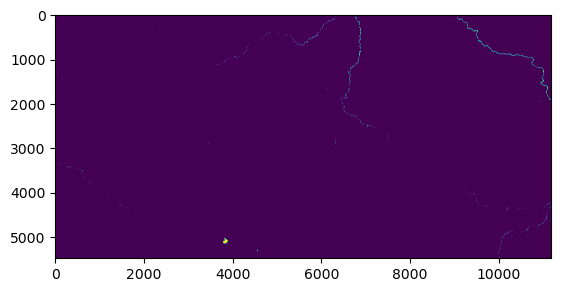

In [128]:
X_esa_water = (np.isin(X_esa, [0, 80]))[0, ...]
plt.imshow(X_esa_water)

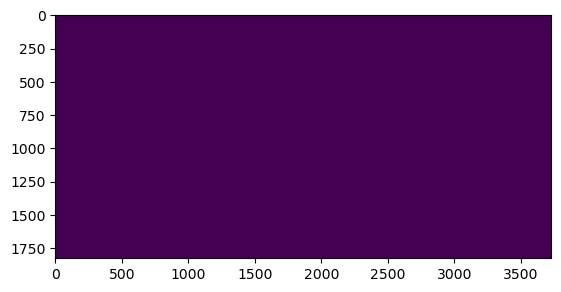

In [129]:
X_pekel_water = (X_pekel > 99)[0, ...]
plt.imshow(X_pekel_water)

# Reproject everything

In [130]:
src_profile = p_pekel.copy()
src_profile['dtype'] = np.uint8
src_profile['nodata'] = 255

X_p_r, p_pekel_r = reproject_arr_to_match_profile(X_pekel_water.astype(np.uint8), src_profile, ref_profile, resampling='nearest')

In [131]:
src_profile = p_esa.copy()
src_profile['dtype'] = np.float32
src_profile['nodata'] = np.nan

X_esa_r, p_esa_r = reproject_arr_to_match_profile(X_esa_water.astype(np.float32), src_profile, ref_profile, resampling='average')

In [132]:
X_esa_water_r = (X_esa_r > .5).astype(np.uint8)

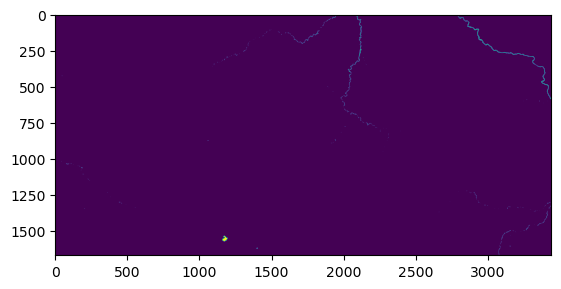

In [133]:
X_water_final = X_esa_water_r | X_p_r

plt.imshow(X_water_final[0, ...])

In [135]:
with rasterio.open(external_data_dir / 'water_mask_esa_and_pekel99.tif', 'w', **p_esa_r) as ds:
    ds.write(X_water_final)